In [15]:
import numpy as np
import pandas as pd
import pylab as pl
from matplotlib.dates import MonthLocator, YearLocator
import sklearn
from sklearn import tree
from sklearn.ensemble.forest import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

filename_test = 'test.csv'
filename_train = 'train.csv'
filename_store = 'store.csv'

train = pd.read_csv(filename_train, header=0, low_memory=False)

test = pd.read_csv(filename_test, header=0, low_memory=False)


store_info = pd.read_csv(filename_store, header=0, low_memory=False)

train.Date = pd.to_datetime(train.Date)
test.Date = pd.to_datetime(test.Date)

def print_missing_stats():
    for data_name, data in {'TRAIN': train, 'TEST': test, 'STORE': store_info}.items():
        print(data_name, ' (overall = %d)' % len(data))
        for attribute in data.columns:
            mask = data[attribute].isnull()
            k = len(data[attribute][mask])
            print('%5d (%2d%%)' % (k, 100*k/len(data)), 'missing values in ', attribute) 
        print()
# print_missing_stats()
test.Open.fillna(1)

store_info.CompetitionDistance = store_info.CompetitionDistance.fillna(0)
store_info.CompetitionOpenSinceMonth = store_info.CompetitionOpenSinceMonth.fillna(0).astype(int)
store_info.Promo2SinceWeek = store_info.Promo2SinceWeek.fillna(0)
store_info.Promo2SinceYear = store_info.Promo2SinceYear.fillna(0)

promo_intervals = [np.NaN] + list(store_info.PromoInterval.value_counts().index)
store_info.PromoInterval = store_info.PromoInterval.map(lambda x: promo_intervals.index(x))
# print_missing_stats()
del promo_intervals

### Plotting all sales by day of week and store

In [16]:
# fig, axes = pl.subplots(nrows=7, ncols=1, sharey=True, figsize=(20,100))

# open_df = train[train.Open == 1]
# for day_of_week in range(1, 8):
#     custom_df = open_df[open_df.DayOfWeek == day_of_week] 
#     gp_store = custom_df.groupby('Store')

#     for store, group in gp_store:
#         axes[day_of_week - 1].plot(group['Date'], group['Sales'], 'v--')

#     gp_date = custom_df.groupby('Date')

#     ts_mean = gp_date['Sales'].mean()
#     ts_median = gp_date['Sales'].median()
#     ts_mean.plot(style='r-', linewidth=5, ax=axes[day_of_week - 1], label='mean')
#     ts_median.plot(style='b-', linewidth=5, ax=axes[day_of_week - 1], label='median')


#     axes[day_of_week - 1].set_title('Day ' + str(day_of_week) + '. number of stores = ' + str(len(gp_store)))
#     axes[day_of_week - 1].legend()
#     axes[day_of_week - 1].xaxis.set_major_locator(MonthLocator())
#     axes[day_of_week - 1].grid(True)
# # pl.savefig('all_stores_and_median.png', format='png')
# del axes,fig, ts_mean, custom_df, gp_date, gp_store, open_df, ts_median

### Plotting mean of sales by day of week with different values of categorical features

In [17]:
# def construct_label_name(school_holiday, state_holiday, promo_flag, n_stores):
#     string_school = 'NO SchoolHoliday. '
#     string_state = 'NO StateHoliday. '
#     string_promo = 'NO Promo. '
#     if school_holiday == 1:
#         string_school = string_school[3:]
#     if promo_flag:
#         string_promo = string_promo[3:]
#     if state_holiday != '0':
#         string_state = {'a': 'PublicHoliday. ',
#                         'b': 'EasterHoliday. ',
#                         'c':'Christmas. '}[state_holiday]
#     string_stores = '(' + str(n_stores) + ' stores)'
#     return string_school + string_state + string_promo + string_stores

# fig, axes = pl.subplots(nrows=7, ncols=1, sharey=True, figsize=(20,100))

# open_df = train[train.Open == 1]
# for day_of_week in range(1, 8):
#     day_df = open_df[open_df.DayOfWeek == day_of_week]
#     for school_holiday in [0, 1]:
#         school_df = day_df[day_df.SchoolHoliday == school_holiday]
#         for state_holiday in ['0', 'a', 'b', 'c']:
#             state_df = school_df[school_df.StateHoliday == state_holiday]
#             for promo_flag in [0, 1]:
#                 custom_df = state_df[state_df.Promo == promo_flag]
#                 if not custom_df.empty:
#                     gp_date = custom_df.groupby('Date')
#                     gp_store = custom_df.groupby('Store')
                
#                     ts_mean = gp_date.Sales.mean()
#                     axes[day_of_week - 1].plot(ts_mean.index, ts_mean, 'v--', 
#                                  label=construct_label_name(school_holiday, state_holiday,
#                                                             promo_flag, len(gp_store)))
    
                
#     custom_df = day_df
#     gp_date = custom_df.groupby('Date')
#     gp_store = custom_df.groupby('Store')
#     ts_mean = gp_date.Sales.mean()
#     ts_mean.plot(style='r-', linewidth=1.5, ax=axes[day_of_week - 1],
#                  label='mean (' + str(len(gp_store)) + ' stores)')
#     axes[day_of_week - 1].set_title('Day ' + str(day_of_week))
#     axes[day_of_week - 1].legend()
#     axes[day_of_week - 1].xaxis.set_major_locator(MonthLocator())
#     axes[day_of_week - 1].grid(True)
    
    
# # pl.savefig('median_decomposition.png', format='png')
# del axes,fig, ts_mean, custom_df, gp_date, gp_store, open_df, day_df, school_df, state_df

### Constructing train data

In [18]:
date_range_train = pd.date_range('2013-01-01', '2015-06-13')
date_range_test = pd.date_range('2015-06-14', '2015-07-31')

# 2014 autumn-september with 2013-2014 train
# date_range_train = pd.date_range('2013-01-01', '2014-07-31')
# date_range_test = pd.date_range('2014-08-01', '2014-09-17')

# 2014 autumn-september
# date_range_train = pd.date_range('2013-01-01', '2014-07-31').union(pd.date_range('2014-09-18', '2015-07-31'))
# date_range_test = pd.date_range('2014-08-01', '2014-09-17')

validation = False
train = train[train.Open == 1]
if validation:
    train_date_range = train[train.Date.isin(date_range_train)]
else:
    train_date_range = train
    

train_features = ['Store', 'DayOfWeek', 'Date', 'Promo', 'SchoolHoliday', 'StateHoliday']
train_date_range = train_date_range[train_features + ['Sales']]

def merge_with_store(data, store_info):    
    store_features = ['Store', 'StoreType', 'Assortment','CompetitionDistance', 
                      'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
                      'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
    data = pd.merge(data, store_info[store_features], on='Store', how='left')
    data.CompetitionOpenSinceYear = data.CompetitionOpenSinceYear.fillna(0)
    return data

def get_dummies_values(series, prefix, values):
    new_series = pd.get_dummies(series, prefix=prefix)
    for value in values:
        column_name = prefix + '_' + str(value)
        if column_name not in new_series.columns:
            new_series = new_series.join(pd.Series(np.zeros(len(new_series)), index=new_series.index,
                                                   columns=column_name))
    return new_series

def construct_main_features(data):
    data['Day'] = data.Date.map(lambda d: d.day).astype(int)
    data['Month'] = data.Date.map(lambda d: d.month).astype(int)
    data['Week'] = data.Date.map(lambda d: d.week).astype(int)
    data['DayOfYear'] = data.Date.map(lambda d: d.dayofyear).astype(int)
    data['Year'] = data.Date.map(lambda d: d.year)
   
    data['DiffToday'] = ((pd.datetime(2015, 9, 18) - data.Date)
                                     / np.timedelta64(1, 'D')).astype(int)
    data['DiffNewYear'] = data.Date.map(lambda d: (min(d - pd.datetime(d.year, 1, 1),
                                  pd.datetime(d.year + 1, 12, 31) - d) / np.timedelta64(1, 'D')).astype(int))
    data['DiffFoolDay'] = data.Date.map(lambda d: ((d - pd.datetime(d.year, 4, 1))
                                                                           / np.timedelta64(1, 'D')).astype(int))

    data = data.join(get_dummies_values(data.StateHoliday, prefix='StateHoliday', values=['0', 'a', 'b', 'c']))
    data = data.join(get_dummies_values(data.Month, prefix='Month', values=np.arange(1, 13)))
    data = data.join(get_dummies_values(data.StoreType, prefix='StoreType', values=['a', 'b', 'c', 'd']))
    data = data.join(get_dummies_values(data.Assortment, prefix='Assortment', values=['a', 'b', 'c']))
    data = data.join(get_dummies_values(data.DayOfWeek, prefix='DayOfWeek', values=np.arange(1, 8)))
    data = data.join(get_dummies_values(data.CompetitionOpenSinceMonth, prefix='CompetitionOpenSinceMonth',
                                        values=np.arange(1, 13)))
    
    del data['Date'], data['StateHoliday'], data['Month'],
    del data['StoreType'], data['Assortment'], data['DayOfWeek'],
    del data['CompetitionOpenSinceMonth']
    return data

train_date_range = merge_with_store(train_date_range, store_info)
train_date_range = construct_main_features(train_date_range)

data_train_labels = np.array(train_date_range.Sales)
del train_date_range['Sales']
features = list(train_date_range.columns)
print(features)
print('Number of features =', len(features))
data_train = np.array(train_date_range)
del train_date_range
print('\nConstructed data_train')

['Store', 'Promo', 'SchoolHoliday', 'CompetitionDistance', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Day', 'Week', 'DayOfYear', 'Year', 'DiffToday', 'DiffNewYear', 'DiffFoolDay', 'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12', 'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_a', 'Assortment_b', 'Assortment_c', 'DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7', 'CompetitionOpenSinceMonth_0', 'CompetitionOpenSinceMonth_1', 'CompetitionOpenSinceMonth_2', 'CompetitionOpenSinceMonth_3', 'CompetitionOpenSinceMonth_4', 'CompetitionOpenSinceMonth_5', 'CompetitionOpenSinceMonth_6', 'CompetitionOpenSinceMonth_7', 'CompetitionOpenSinceMonth_8', 'CompetitionOpenSinceMonth_9', 'CompetitionOpenSinceMonth_10', 'CompetitionOpenS

### Constructing test data

In [19]:
def get_dummies_values(series, prefix, values):
    new_series = pd.get_dummies(series, prefix=prefix)
    for value in values:
        column_name = prefix + '_' + str(value)
        if column_name not in new_series.columns:
            new_series = new_series.join(pd.DataFrame(np.zeros(len(new_series)), index=new_series.index,
                                                      columns=[column_name]))
    return new_series

def construct_test(data):
    data = merge_with_store(data[train_features], store_info)
    data = construct_main_features(data)
    print(list(data.columns))
    print('Number of features =', len(data.columns))
    return np.array(data)

if validation:
    local_test = train[train_features + ['Sales']]
    local_test = local_test[local_test.Date.isin(date_range_test)]
    local_test_labels = np.asarray(local_test.Sales)
    local_test = construct_test(local_test)
    print('Constructed local_test')
else:
    data_test = construct_test(test)
    print('Constructed data_test')
    
test = test[['Id', 'Open']]
del date_range_test, date_range_train, train, store_info

['Store', 'Promo', 'SchoolHoliday', 'CompetitionDistance', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Day', 'Week', 'DayOfYear', 'Year', 'DiffToday', 'DiffNewYear', 'DiffFoolDay', 'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c', 'Month_8', 'Month_9', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_10', 'Month_11', 'Month_12', 'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_a', 'Assortment_b', 'Assortment_c', 'DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7', 'CompetitionOpenSinceMonth_0', 'CompetitionOpenSinceMonth_1', 'CompetitionOpenSinceMonth_2', 'CompetitionOpenSinceMonth_3', 'CompetitionOpenSinceMonth_4', 'CompetitionOpenSinceMonth_5', 'CompetitionOpenSinceMonth_6', 'CompetitionOpenSinceMonth_7', 'CompetitionOpenSinceMonth_8', 'CompetitionOpenSinceMonth_9', 'CompetitionOpenSinceMonth_10', 'CompetitionOpenS

### Predicting

 0 (feature  3): CompetitionDistance Importance = 0.18347
 1 (feature  1): Promo Importance = 0.14938
 2 (feature  0): Store Importance = 0.13244
 3 (feature  4): CompetitionOpenSinceYear Importance = 0.06393
 4 (feature  6): Promo2SinceYear Importance = 0.03535
 5 (feature  5): Promo2SinceWeek Importance = 0.03493
 6 (feature 43): DayOfWeek_6 Importance = 0.02587
 7 (feature  8): Day Importance = 0.02572
 8 (feature 12): DiffToday Importance = 0.02362
 9 (feature 38): DayOfWeek_1 Importance = 0.02258
10 (feature 31): StoreType_a Importance = 0.01945
11 (feature  7): PromoInterval Importance = 0.01860
12 (feature 13): DiffNewYear Importance = 0.01810
13 (feature 14): DiffFoolDay Importance = 0.01761
14 (feature 32): StoreType_b Importance = 0.01648
15 (feature 35): Assortment_a Importance = 0.01552
16 (feature 10): DayOfYear Importance = 0.01542
17 (feature 34): StoreType_d Importance = 0.01093
18 (feature 48): CompetitionOpenSinceMonth_3 Importance = 0.01057
19 (feature 33): StoreType

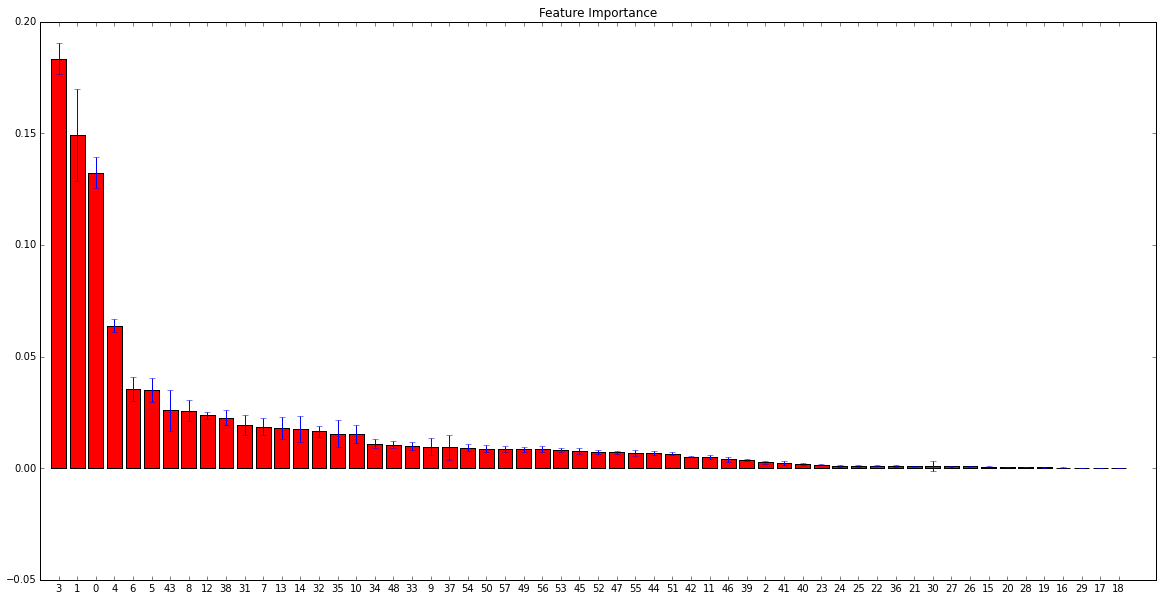

In [20]:
def visualize_feature_importances(clf, features):
    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
    sorted_indices = np.argsort(importances)[::-1]
    for i, k in enumerate(sorted_indices):
        print('%2d (feature %2d):' % (i, k), features[k], 'Importance = %.5f' % importances[k])
    pl.figure(figsize=(20,10))
    pl.title('Feature Importance')
    pl.bar(range(len(features)), importances[sorted_indices], 
           color='r', yerr=std[sorted_indices], align='center')
    pl.xticks(range(len(features)), sorted_indices)
    pl.xlim([-1, len(features) + 1])
#     pl.savefig('feature_importance.png', format='png')
    
def compute_RMSPE(test_labels, predicted_labels):
    mask = test_labels.nonzero()
    y = test_labels[mask]
    y_hat = predicted_labels[mask]
    return np.sqrt(np.mean(((y - y_hat)/y)**2))

def visualize_RMSPE(test_labels, predicted_labels, step = 0.05):
    for i in np.arange(0, 1, step):
        pl.figure(figsize=(20,7))
        pl.plot(test_labels[i*len(test_labels):(i+step)*len(test_labels)],
                'b.', label='real')
        pl.plot(predicted_labels[i*len(predicted_labels):(i+step)*len(predicted_labels)],
                'r.', label='predicted')
        pl.legend()

rmspe_s, alphas = [], []
min_rmspe, min_alpha = 1., 0.

# grid_space = np.asarray(np.exp(np.linspace(2.2, 4.4, 20)), dtype=int)
# grid_space = np.arange(1, len(features) + 1)/len(features) # grid_space for max_features
grid_space = [1]

for alpha in grid_space:
    clf = RandomForestRegressor(n_estimators=30, n_jobs=-1, min_samples_leaf=2, max_features=0.464285714286)
    
    clf.fit(data_train, np.log(data_train_labels + 1))
    
    if len(grid_space) <= 1 and hasattr(clf, 'feature_importances_'):
        visualize_feature_importances(clf, features)
    elif len(grid_space) <= 1 and hasattr(clf, 'coef_'):
        print('Coef =', clf.coef_)
    else:
        print('trying alpha =', alpha)
        
    if validation:
        predicted_test_labels = np.exp(clf.predict(local_test)) - 1
        loss_score = compute_RMSPE(local_test_labels, predicted_test_labels)
        print('RMSPE on date_range_test =', loss_score)
#         visualize_RMSPE(local_test_labels, predicted_test_labels)
        if loss_score <= min_rmspe:
            min_rmspe = loss_score
            min_alpha = alpha
        alphas.append(alpha)
        rmspe_s.append(loss_score)

    elif not validation and len(grid_space) <= 1:
        data_test_labels = np.exp(clf.predict(data_test)) - 1
        test['Sales'] = data_test_labels
        test.ix[test.Open == 0, 'Sales'] = 0
        test[['Id', 'Sales']].to_csv('prediction.csv', index=False)
        print('\nResult was written to prediction.csv')
    del clf

if len(grid_space) > 1:
    print('Min RMSPE =', min_rmspe, 'Min alpha =', min_alpha)
    pl.figure(figsize=(20,10))
    pl.plot(alphas, rmspe_s, 'r.--')
    pl.savefig('grid_parameters.png', format='png')